## Ascending input vs. descending input vs. combined ascending and descending input

In [1]:
import os
os.chdir('..')
from glob import glob
from notebooks import config
import numpy as np
import pandas as pd
import seaborn as sns
from utils.imgShow import imgShow, imsShow
import matplotlib.pyplot as plt
from utils.metrics_plot import csv_merge, smooth
from utils.metric import acc_matrix, acc_miou
from utils.raster_vec import vec2mask
from utils.geotif_io import readTiff
from matplotlib.pyplot import MultipleLocator
from matplotlib.colors import ListedColormap


In [2]:
### baseline: combined ascending and descending images
path_testsite_s1scene = glob(config.root_proj+'/data/dset/s1_as_des/*'); path_testsite_s1scene.sort()
path_testsite_s2scene = glob(config.root_proj + '/data/dset/s2_img/*'); path_testsite_s2scene.sort()
path_testsite_truth = glob(config.root_proj+'/data/dset/s1_truth/*0?_wat*.tif'); path_testsite_truth.sort()
path_testsite_wats = glob(config.root_proj+'/data/dset/s1_water_test_gscales/*'); path_testsite_wats.sort()
path_testsite_wats_as = glob(config.root_proj+'/data/dset/s1_water_test_as/*'); path_testsite_wats_as.sort()
path_testsite_wats_des = glob(config.root_proj+'/data/dset/s1_water_test_des/*'); path_testsite_wats_des.sort()


#### 1. Check accuracy during model training

In [17]:
##### selection for test scene mapping: 
##### as -> 6: 87.3; 
##### des -> 7: 94.1
##### as_des -> 2: 95.4.
####################################################################
## 1. Model name and the selected metric
# id_model =  '10'
# model_name = ['model_single_test_'+id_model, 'model_scales_test_'+id_model, 'model_gscales_test_'+id_model]
model_name = ['gscales_as_test_6', 'gscales_des_test_fine', 'model_gscales_test_9']

# metric_name = 'val_miou'
path_metrics_as = config.root_proj + '/model/pretrained/gscales_as_test/' + model_name[0] + '_metrics.csv'
path_metrics_des = config.root_proj + '/model/pretrained/gscales_des_test/' + model_name[1] + '_metrics.csv'
path_metrics_as_des = config.root_proj + '/model/pretrained/model_gscales_test/' + model_name[2] + '_metrics.csv'

## 2. Read metric file (each file corresponding to one model and contains all metrics)
metrics_as = pd.read_csv(path_metrics_as)
metrics_des = pd.read_csv(path_metrics_des)
metrics_as_des = pd.read_csv(path_metrics_as_des)
# metrics_as_des.tail(2)
metrics_des.tail(2)



,tra_loss,tra_miou,val_loss,val_miou
198,0.336393,0.946436,0.155593,0.934020
199,0.337502,0.958932,0.155592,0.934021


### 2. Accuracy assessment for each test scene and each pretrained model(different input).

In [3]:
oa, miou, oa_as, miou_as, oa_des, miou_des = [], [], [], [], [], []
scenes, truths, wats, wats_as, wats_des = [], [], [], [], []

for idx in range(7):
    scene, scene_info = readTiff(path_testsite_s1scene[idx])
    truth, truth_info = readTiff(path_testsite_truth[idx])
    wat, wat_info = readTiff(path_testsite_wats[idx])
    wat_as, wat_as_info = readTiff(path_testsite_wats_as[idx])
    wat_des, wat_des_info = readTiff(path_testsite_wats_des[idx])
    scenes.append(scene); truths.append(truth); 
    wats.append(wat); wats_as.append(wat_as); wats_as.append(wat_as)
    ### combined ascending and descending input
    oa_i, prod_i, user_i, confus_mat_i = acc_matrix(cla_map=wat, truth_map=truth, id_label=1)
    miou_i = acc_miou(cla_map=wat, truth_map=truth, labels=[1])
    oa.append(float(format(oa_i, '.4f'))), miou.append(float(format(miou_i, '.4f')))
    ### ascending input only
    oa_as_i, _, _, _ = acc_matrix(cla_map=wat_as, truth_map=truth, id_label=1)
    miou_as_i = acc_miou(cla_map=wat_as, truth_map=truth, labels=[1])
    oa_as.append(float(format(oa_as_i, '.4f'))), miou_as.append(float(format(miou_as_i, '.4f')))
    ### descending input only
    oa_des_i, _, _, _ = acc_matrix(cla_map=wat_des, truth_map=truth, id_label=1)
    miou_des_i = acc_miou(cla_map=wat_des, truth_map=truth, labels=[1])
    oa_des.append(float(format(oa_des_i, '.4f'))), miou_des.append(float(format(miou_des_i, '.4f')))

print('oa_as :', oa_as)
print('oa_des:', oa_des)
print('oa:    ', oa)
print('miou_as :', miou_as)
print('miou_des:', miou_des)
print('miou:    ', miou)



oa_as : [0.989, 0.9704, 0.9376, 0.9128, 0.9921, 0.98, 0.9796]
oa_des: [0.9954, 0.9859, 0.923, 0.9805, 0.9934, 0.9946, 0.9545]
oa:     [0.9977, 0.9854, 0.9775, 0.9627, 0.996, 0.9949, 0.9964]
miou_as : [0.9135, 0.7544, 0.7858, 0.194, 0.9173, 0.9203, 0.9441]
miou_des: [0.9628, 0.8801, 0.7367, 0.7874, 0.9307, 0.9777, 0.8704]
miou:     [0.9807, 0.8779, 0.9213, 0.6175, 0.9567, 0.9788, 0.9897]


#### Save the accuracy metrics to .csv file

In [5]:
# model_id = 10
# path_metrics = '/home/yons/Desktop/developer-luo/Monthly-Surface-Water-in-Tibet/data/dset/metrics_as_des_in/as_des_input_test_' + str(model_id) + '.csv'
# # metrics = {'oa': oa, 'oa_as': oa_as, 'oa_des': oa_des, \
# #                           'miou':miou, 'miou_as':miou_as, 'miou_des':miou_des, 'model_id': model_id}
# # metrics_df = pd.DataFrame(metrics)
# metrics_df = pd.read_csv(path_metrics)
# metrics_df.to_csv(path_metrics, index=False, sep=',')
# metrics_df



### 3. Concat metrics obtained by different iteration

In [5]:
metrics_paths = glob('/home/yons/Desktop/developer-luo/Monthly-Surface-Water-in-Tibet/data/dset/metrics_as_des_in/*')
metrics_models = csv_merge(metrics_paths, i_row='scene_id')
metrics_models



,oa,oa_as,oa_des,miou,miou_as,miou_des,model_id,scene_id
0,0.9939,0.9855,0.9931,0.9513,0.8853,0.9452,1,1
1,0.9856,0.9418,0.9847,0.8790,0.4932,0.8679,1,2
2,0.9726,0.8950,0.9508,0.9039,0.6249,0.8296,1,3
3,0.9492,0.9126,0.9634,0.4841,0.1970,0.5922,1,4
4,0.9971,0.9855,0.9950,0.9684,0.8586,0.9468,1,5
...,...,...,...,...,...,...,...,...
65,0.9679,0.9174,0.9112,0.8882,0.7074,0.6877,8,3
66,0.9518,0.9098,0.9625,0.4615,0.1429,0.6017,8,4
67,0.9972,0.9958,0.9952,0.9697,0.9547,0.9490,8,5
68,0.9905,0.9877,0.9957,0.9610,0.9495,0.9820,8,6


### 4. Comparison among orbital data ( box plot with confidence interval)


In [14]:
###  append the mean values (among the test sites)
metrics_mean = metrics_models.groupby('scene_id').mean()
metrics_mean['scene_id'] = 'Average'
metrics_models_ = pd.concat([metrics_models, metrics_mean])
metrics_models_

,oa,oa_as,oa_des,miou,miou_as,miou_des,model_id,scene_id
0,0.99390,0.98550,0.99310,0.95130,0.88530,0.94520,1.0,1
1,0.98560,0.94180,0.98470,0.87900,0.49320,0.86790,1.0,2
2,0.97260,0.89500,0.95080,0.90390,0.62490,0.82960,1.0,3
3,0.94920,0.91260,0.96340,0.48410,0.19700,0.59220,1.0,4
4,0.99710,0.98550,0.99500,0.96840,0.85860,0.94680,1.0,5
...,...,...,...,...,...,...,...,...
3,0.97524,0.88738,0.94178,0.91397,0.60392,0.80148,5.5,Average
4,0.95515,0.89823,0.96206,0.50922,0.15245,0.60221,5.5,Average
5,0.99659,0.98834,0.99424,0.96323,0.88377,0.93960,5.5,Average
6,0.98860,0.98288,0.99364,0.95376,0.93077,0.97359,5.5,Average


In [15]:
oa = list(metrics_models_['oa']) + list(metrics_models_['oa_as']) + list(metrics_models_['oa_des'])
models_name = ['Combined ascending and descending images' for i in range(77)] \
            + ['Ascending image only' for i in range(77)] \
            + ['Descending image only' for i in range(77)]

scene_id = list(metrics_models_['scene_id'])*3
metrics_oa = {'oa': oa, 'Input image': models_name, 'scene_id': scene_id}
metrics_oa = pd.DataFrame(metrics_oa)
metrics_oa



,oa,Input image,scene_id
0,0.99390,Combined ascending and descending images,1
1,0.98560,Combined ascending and descending images,2
2,0.97260,Combined ascending and descending images,3
3,0.94920,Combined ascending and descending images,4
4,0.99710,Combined ascending and descending images,5
...,...,...,...
226,0.94178,Descending image only,Average
227,0.96206,Descending image only,Average
228,0.99424,Descending image only,Average
229,0.99364,Descending image only,Average


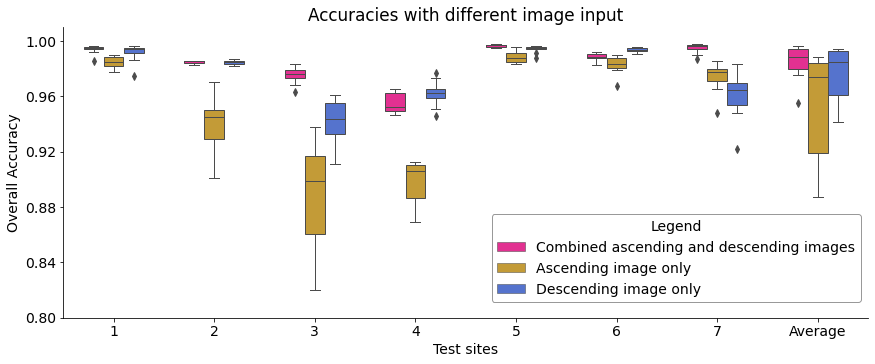

In [16]:
plt.rcParams.update({'font.size': 14})
# colors = ['red', 'blue', 'green']
colors = ['DeepPink', 'Goldenrod', 'RoyalBlue']
g = sns.catplot(data=metrics_oa, x= "scene_id", y = "oa", 
                hue='Input image', kind="box", legend = False,
                width=0.6, palette=colors, linewidth=1,
                height=5, aspect=2.5, ci=90)
g.set(ylim=(0.80, 1.01))\
  .set(xlabel='Test sites',ylabel='Overall Accuracy',title='Accuracies with different image input')
ax = plt.gca()
y_major_locator=MultipleLocator(0.04)
ax.yaxis.set_major_locator(y_major_locator)
plt.legend(title='Legend', loc = 'lower right', fontsize='medium', edgecolor='gray',bbox_to_anchor=(1,0.03))
# plt.savefig(config.root_proj + '/figure/image_input_compare.png', bbox_inches='tight')


### 5. Show the water maps derived by different image input


In [4]:
s1scenes, s2scenes, truths = [], [], []
s2_scenes = []
wats_as, wats_des, wats = [], [], []
for idx in range(7):
    s1scene, s1scene_info = readTiff(path_testsite_s1scene[idx])
    s2scene, s2scene_info = readTiff(path_testsite_s2scene[idx])
    truth, truth_info = readTiff(path_testsite_truth[idx])
    wat, wat_info = readTiff(path_testsite_wats[idx])
    wat_as, wat_as_info = readTiff(path_testsite_wats_as[idx])
    wat_des, wat_des_info = readTiff(path_testsite_wats_des[idx])    
    s1scenes.append(s1scene); truths.append(truth); s2scenes.append(s2scene)
    wats.append(wat); wats_as.append(wat_as); wats_des.append(wat_des)



#### **Combined image outperform the single-orbit image only**

size: (3509, 3962)


Text(0.5, 1.0, 'Descending image only')

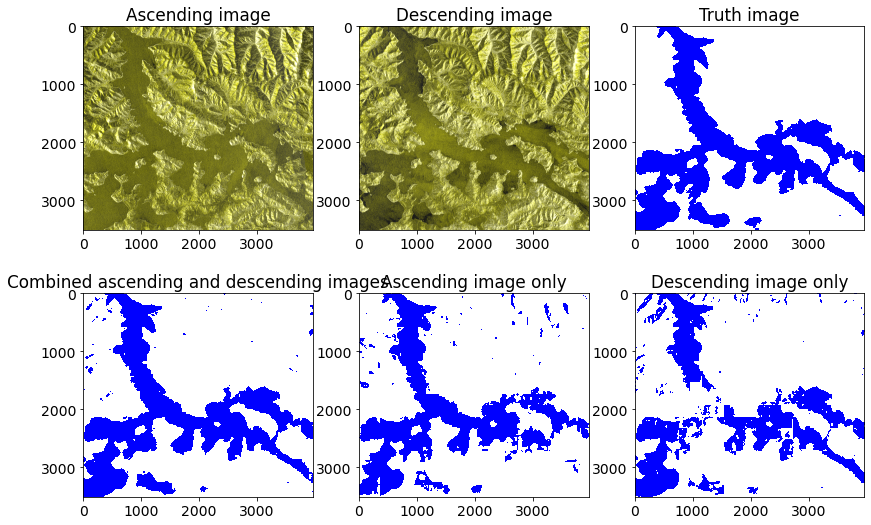

In [26]:
idx = 2
print('size:', truths[idx].shape)
cmap_wat = ListedColormap(["white", "blue"])
plt.figure(figsize=(14,9))
plt.subplot(2,3,1); imgShow(s1scenes[idx][:,:,0:2], color_bands=(0,0,1)); plt.title('Ascending image')
plt.subplot(2,3,2); imgShow(s1scenes[idx][:,:,2:4], color_bands=(0,0,1)); plt.title('Descending image')
plt.subplot(2,3,3); plt.imshow(truths[idx], cmap=cmap_wat); plt.title('Truth image')
plt.subplot(2,3,4); plt.imshow(wats[idx], cmap=cmap_wat); plt.title('Combined ascending and descending images')
plt.subplot(2,3,5); plt.imshow(wats_as[idx], cmap=cmap_wat); plt.title('Ascending image only')
plt.subplot(2,3,6); plt.imshow(wats_des[idx], cmap=cmap_wat); plt.title('Descending image only')



Text(0.5, 1.0, 'Descending image only')

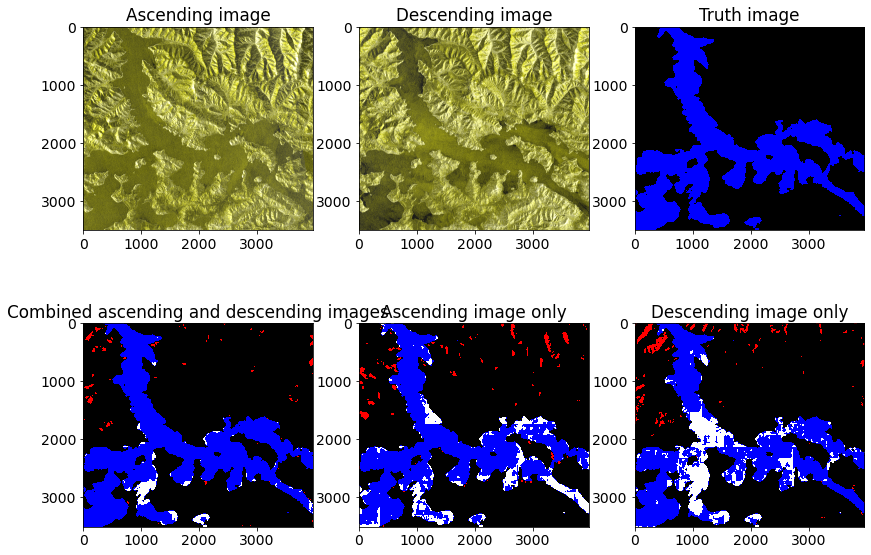

In [19]:
plt.rcParams.update({'font.size': 14})
cmap_dif = ListedColormap(['red', 'black', 'blue','white'])

dif_as = (truths[idx]+1)*2 - wats_as[idx]
dif_des = (truths[idx]+1)*2 - wats_des[idx]
dif_as_des = (truths[idx]+1)*2 - wats[idx]
plt.figure(figsize=(14,10))
plt.subplot(2,3,1); imgShow(s1scenes[idx][:,:,0:2], color_bands=(0,0,1)); plt.title('Ascending image')
plt.subplot(2,3,2); imgShow(s1scenes[idx][:,:,2:4], color_bands=(0,0,1)); plt.title('Descending image')
plt.subplot(2,3,3); plt.imshow(truths[idx], cmap=cmap_wat); plt.title('Truth image')
plt.subplot(2,3,4); plt.imshow(dif_as_des, cmap=cmap_dif); plt.title('Combined ascending and descending images')
plt.subplot(2,3,5); plt.imshow(dif_as, cmap=cmap_dif); plt.title('Ascending image only')
plt.subplot(2,3,6); plt.imshow(dif_des, cmap=cmap_dif); plt.title('Descending image only')


#### **Single-orbit image only outperform the combined image input.**

size: (3569, 4084)


Text(0.5, 1.0, 'Descending image only')

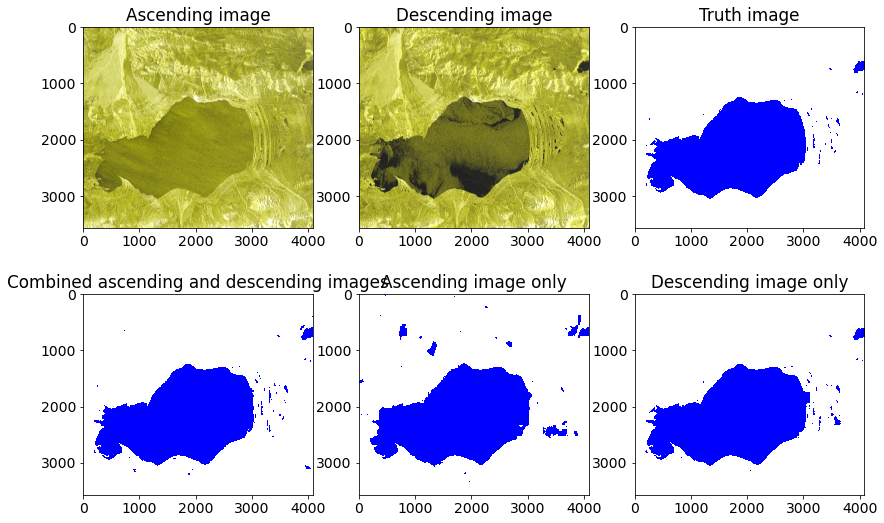

In [7]:
idx = 5
print('size:', truths[idx].shape)
cmap_wat = ListedColormap(["white", "blue"])
plt.figure(figsize=(14,9))
plt.subplot(2,3,1); imgShow(s1scenes[idx][:,:,0:2], color_bands=(0,0,1)); plt.title('Ascending image')
plt.subplot(2,3,2); imgShow(s1scenes[idx][:,:,2:4], color_bands=(0,0,1)); plt.title('Descending image')
plt.subplot(2,3,3); plt.imshow(truths[idx], cmap=cmap_wat); plt.title('Truth image')
plt.subplot(2,3,4); plt.imshow(wats[idx], cmap=cmap_wat); plt.title('Combined ascending and descending images')
plt.subplot(2,3,5); plt.imshow(wats_as[idx], cmap=cmap_wat); plt.title('Ascending image only')
plt.subplot(2,3,6); plt.imshow(wats_des[idx], cmap=cmap_wat); plt.title('Descending image only')



Text(0.5, 1.0, 'Descending image only')

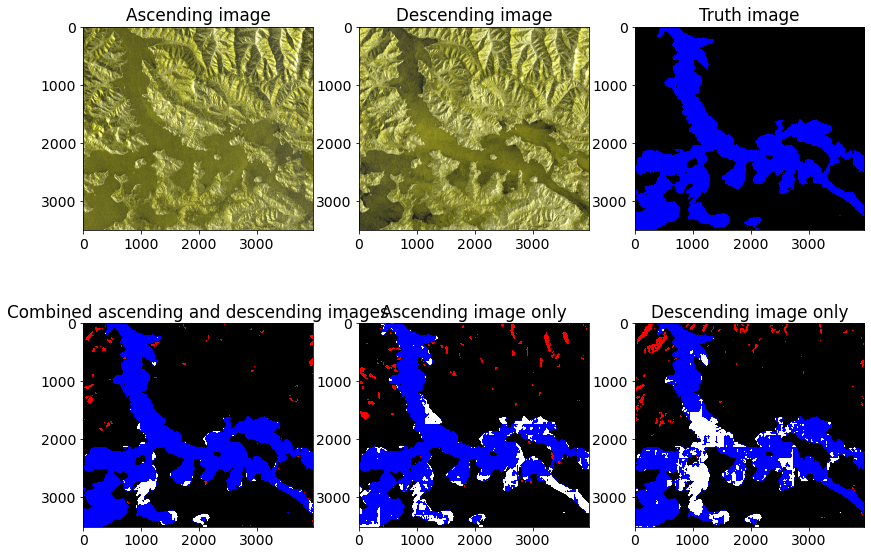

In [25]:
plt.rcParams.update({'font.size': 14})
cmap_truth = ListedColormap(["white", "blue"])
cmap_dif = ListedColormap(['red', 'black', 'blue','white'])

dif_as = (truths[idx]+1)*2 - wats_as[idx]
dif_des = (truths[idx]+1)*2 - wats_des[idx]
dif_as_des = (truths[idx]+1)*2 - wats[idx]
plt.figure(figsize=(14,10))
plt.subplot(2,3,1); imgShow(s1scenes[idx][:,:,0:2], color_bands=(0,0,1), clip_percent=1); plt.title('Ascending image')
plt.subplot(2,3,2); imgShow(s1scenes[idx][:,:,2:4], color_bands=(0,0,1), clip_percent=1); plt.title('Descending image')
plt.subplot(2,3,3); plt.imshow(truths[idx], cmap=cmap_wat); plt.title('Truth image')
plt.subplot(2,3,4); plt.imshow(dif_as_des, cmap=cmap_dif); plt.title('Combined ascending and descending images')
plt.subplot(2,3,5); plt.imshow(dif_as, cmap=cmap_dif); plt.title('Ascending image only')
plt.subplot(2,3,6); plt.imshow(dif_des, cmap=cmap_dif); plt.title('Descending image only')

